In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
import shap

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-15 07:48:32.215146: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 07:48:32.281931: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 07:48:33.483624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0815_variable.csv')
test = pd.read_csv('./data/test_0815_variable.csv')

In [5]:
train.columns

Index(['target', 'inconsistant', 'distance_diff_dam_fill1_stage1',
       'distance_diff_dam_fill2_stage1', 'distance_diff_fill1_fill2_stage1',
       'distance_diff_dam_fill1_stage2', 'distance_diff_dam_fill2_stage2',
       'distance_diff_fill1_fill2_stage2', 'distance_diff_dam_fill1_stage3',
       'distance_diff_dam_fill2_stage3', 'distance_diff_fill1_fill2_stage3',
       'cure_time_dam', 'cure_time_fill2', 'press21_autoclave', 'thon_time',
       'discharged_dist_stage1_dam', 'discharged_dist_stage2_dam',
       'discharged_dist_stage3_dam', 'equip', 'dam_time', 'fill1_time',
       'fill2_time', 'autoclave_time', 'pallet', 'qty', 'receip',
       'chamber_temp', 'model_suffix', 'select_workorder', 'direction'],
      dtype='object')

In [6]:
train['pallet'] = train['pallet'].astype('int64')
test['pallet'] = test['pallet'].astype('int64')

In [7]:
# 학습시 inconsistant 전부 빼고 적용
train_sel = train[train['inconsistant'] == 0]

In [8]:
# 각 영역별 
dam = ['target', 'distance_diff_dam_fill1_stage1',
       'distance_diff_dam_fill2_stage1', 'distance_diff_fill1_fill2_stage1',
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 'dam_time', 'fill1_time',
       'fill2_time',
       'discharged_dist_stage1_dam',
       'equip', 'pallet', 'receip', 'select_workorder', 'direction', 
       'model_suffix']

fill1 = [
        'target', 
       'distance_diff_dam_fill1_stage2', 'distance_diff_dam_fill2_stage2',
       'distance_diff_fill1_fill2_stage2', 
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 'dam_time', 'fill1_time',
       'fill2_time',
       'discharged_dist_stage2_dam',
       'equip', 'pallet', 'receip', 'select_workorder', 'direction', 
       'model_suffix'
        ]

fill2 = [
        'target', 'distance_diff_dam_fill1_stage3',
       'distance_diff_dam_fill2_stage3', 'distance_diff_fill1_fill2_stage3',
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 'dam_time', 'fill1_time',
       'fill2_time',
       'discharged_dist_stage3_dam',
       'equip', 'pallet', 'receip', 'select_workorder', 'direction', 
       'model_suffix'
]

autoclave = [
        'target',
       'press21_autoclave',
        'equip', 'autoclave_time', 'pallet', 'receip',
       'chamber_temp', 'model_suffix', 'select_workorder'
            ]

df_dam = train_sel[dam]
df_fill1 = train_sel[fill1]
df_fill2 = train_sel[fill2]
df_autoclave = train_sel[autoclave]

# Stage1

In [9]:
X_dam = df_dam.drop(columns=['target'])
y_dam = df_dam['target']

cat_features_indices_dam = ['pallet', 'receip', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_dam, y_dam, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_dam)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_dam)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 07:48:35,487] A new study created in memory with name: no-name-2189ad62-e363-4fb3-a9cb-4c156bc0e553
[I 2024-08-15 07:48:43,256] Trial 0 finished with value: 0.5815073715050096 and parameters: {'iterations': 440, 'depth': 9, 'learning_rate': 0.001437730095774868, 'l2_leaf_reg': 4.164327718756562, 'border_count': 110, 'random_strength': 5.513467577083339, 'bagging_temperature': 0.5964598335440883, 'od_type': 'IncToDec', 'od_wait': 27, 'boosting_type': 'Plain', 'scale_pos_weight': 14}. Best is trial 0 with value: 0.5815073715050096.
[I 2024-08-15 07:48:55,133] Trial 1 finished with value: 0.48836551643138254 and parameters: {'iterations': 995, 'depth': 4, 'learning_rate': 0.027562380440099708, 'l2_leaf_reg': 6.438293657768883, 'border_count': 77, 'random_strength': 3.4879166432114386, 'bagging_temperature': 0.4578548977708494, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Ordered', 'scale_pos_weight': 18}. Best is trial 0 with value: 0.5815073715050096.
[I 2024-08-15 0

Best trial:
  Value: 0.5837535718035849
  Params: 
    iterations: 701
    depth: 5
    learning_rate: 0.004601751349192884
    l2_leaf_reg: 9.754051645242193
    border_count: 104
    random_strength: 5.0444144044350665
    bagging_temperature: 0.8403992592617056
    od_type: Iter
    od_wait: 36
    boosting_type: Ordered
    scale_pos_weight: 8


In [10]:
study.best_trial.params

{'iterations': 701,
 'depth': 5,
 'learning_rate': 0.004601751349192884,
 'l2_leaf_reg': 9.754051645242193,
 'border_count': 104,
 'random_strength': 5.0444144044350665,
 'bagging_temperature': 0.8403992592617056,
 'od_type': 'Iter',
 'od_wait': 36,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 8}

In [12]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(**dam_best_params)
dam_best_model.fit(X_train, y_train, cat_features=cat_features_indices_dam)

0:	learn: 0.6921621	total: 22.6ms	remaining: 15.8s
1:	learn: 0.6913622	total: 60.1ms	remaining: 21s
2:	learn: 0.6902903	total: 96.7ms	remaining: 22.5s
3:	learn: 0.6892851	total: 135ms	remaining: 23.5s
4:	learn: 0.6875228	total: 173ms	remaining: 24.1s
5:	learn: 0.6867547	total: 211ms	remaining: 24.4s
6:	learn: 0.6850805	total: 252ms	remaining: 25s
7:	learn: 0.6841137	total: 286ms	remaining: 24.8s
8:	learn: 0.6831002	total: 326ms	remaining: 25.1s
9:	learn: 0.6821886	total: 352ms	remaining: 24.3s
10:	learn: 0.6811806	total: 391ms	remaining: 24.6s
11:	learn: 0.6805688	total: 414ms	remaining: 23.8s
12:	learn: 0.6796103	total: 452ms	remaining: 23.9s
13:	learn: 0.6779595	total: 490ms	remaining: 24s
14:	learn: 0.6770857	total: 521ms	remaining: 23.8s
15:	learn: 0.6761445	total: 549ms	remaining: 23.5s
16:	learn: 0.6752405	total: 578ms	remaining: 23.3s
17:	learn: 0.6745849	total: 601ms	remaining: 22.8s
18:	learn: 0.6736914	total: 627ms	remaining: 22.5s
19:	learn: 0.6730443	total: 653ms	remaining:

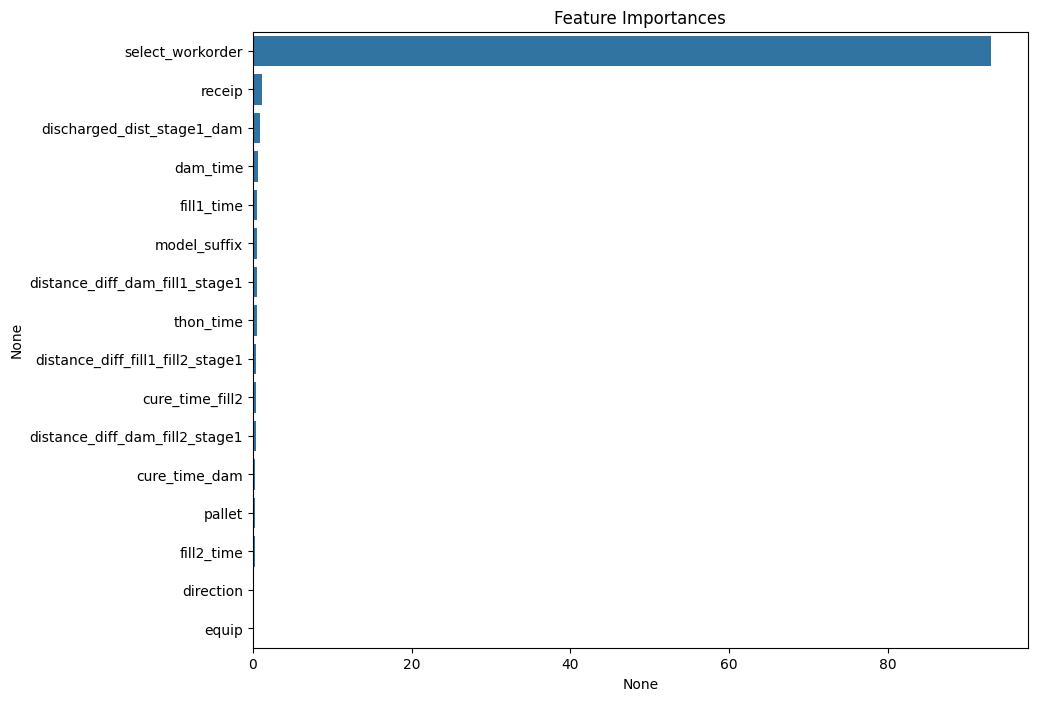

In [13]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(dam_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [14]:
pred = dam_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 140  340]
 [ 614 6989]]

정확도: 0.8820
정밀도: 0.1857
재현율: 0.2917
F1: 0.2269


# Stage2

In [15]:
X_fill1 = df_fill1.drop(columns=['target'])
y_fill1 = df_fill1['target']

cat_features_indices_fill1 = ['pallet', 'receip', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_fill1, y_fill1, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_fill1)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_fill1)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 07:58:53,652] A new study created in memory with name: no-name-69323760-2f91-4f64-bb44-18d2cc41b035
[I 2024-08-15 07:59:11,141] Trial 0 finished with value: 0.5740033373705705 and parameters: {'iterations': 792, 'depth': 7, 'learning_rate': 0.026888881317925908, 'l2_leaf_reg': 7.062257695971484, 'border_count': 67, 'random_strength': 8.553924665616098, 'bagging_temperature': 0.19464081010518686, 'od_type': 'Iter', 'od_wait': 50, 'boosting_type': 'Ordered', 'scale_pos_weight': 6}. Best is trial 0 with value: 0.5740033373705705.
[I 2024-08-15 07:59:25,607] Trial 1 finished with value: 0.5008131420219445 and parameters: {'iterations': 796, 'depth': 5, 'learning_rate': 0.0013025676659942692, 'l2_leaf_reg': 8.984754918180146, 'border_count': 216, 'random_strength': 5.261293146544341, 'bagging_temperature': 0.5947585686479457, 'od_type': 'Iter', 'od_wait': 16, 'boosting_type': 'Ordered', 'scale_pos_weight': 4}. Best is trial 0 with value: 0.5740033373705705.
[I 2024-08-15 07:59

Best trial:
  Value: 0.5818112418570012
  Params: 
    iterations: 684
    depth: 9
    learning_rate: 0.0035806739569867042
    l2_leaf_reg: 5.809964454358588
    border_count: 42
    random_strength: 2.9741505355110376
    bagging_temperature: 0.0009045741447141209
    od_type: Iter
    od_wait: 36
    boosting_type: Plain
    scale_pos_weight: 8


In [16]:
study.best_trial.params

{'iterations': 684,
 'depth': 9,
 'learning_rate': 0.0035806739569867042,
 'l2_leaf_reg': 5.809964454358588,
 'border_count': 42,
 'random_strength': 2.9741505355110376,
 'bagging_temperature': 0.0009045741447141209,
 'od_type': 'Iter',
 'od_wait': 36,
 'boosting_type': 'Plain',
 'scale_pos_weight': 8}

In [17]:
# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(**fill1_best_params)
fill1_best_model.fit(X_train, y_train, cat_features=cat_features_indices_fill1)

0:	learn: 0.6923802	total: 11.6ms	remaining: 7.93s
1:	learn: 0.6915276	total: 32.2ms	remaining: 11s
2:	learn: 0.6906524	total: 60ms	remaining: 13.6s
3:	learn: 0.6897898	total: 85.7ms	remaining: 14.6s
4:	learn: 0.6889826	total: 100ms	remaining: 13.6s
5:	learn: 0.6882003	total: 118ms	remaining: 13.4s
6:	learn: 0.6868090	total: 132ms	remaining: 12.7s
7:	learn: 0.6854424	total: 151ms	remaining: 12.8s
8:	learn: 0.6847241	total: 159ms	remaining: 11.9s
9:	learn: 0.6839886	total: 168ms	remaining: 11.3s
10:	learn: 0.6826395	total: 186ms	remaining: 11.4s
11:	learn: 0.6812116	total: 195ms	remaining: 10.9s
12:	learn: 0.6799154	total: 215ms	remaining: 11.1s
13:	learn: 0.6791477	total: 235ms	remaining: 11.2s
14:	learn: 0.6783394	total: 262ms	remaining: 11.7s
15:	learn: 0.6769706	total: 276ms	remaining: 11.5s
16:	learn: 0.6762033	total: 297ms	remaining: 11.7s
17:	learn: 0.6754396	total: 312ms	remaining: 11.6s
18:	learn: 0.6747810	total: 319ms	remaining: 11.2s
19:	learn: 0.6739949	total: 338ms	remaini

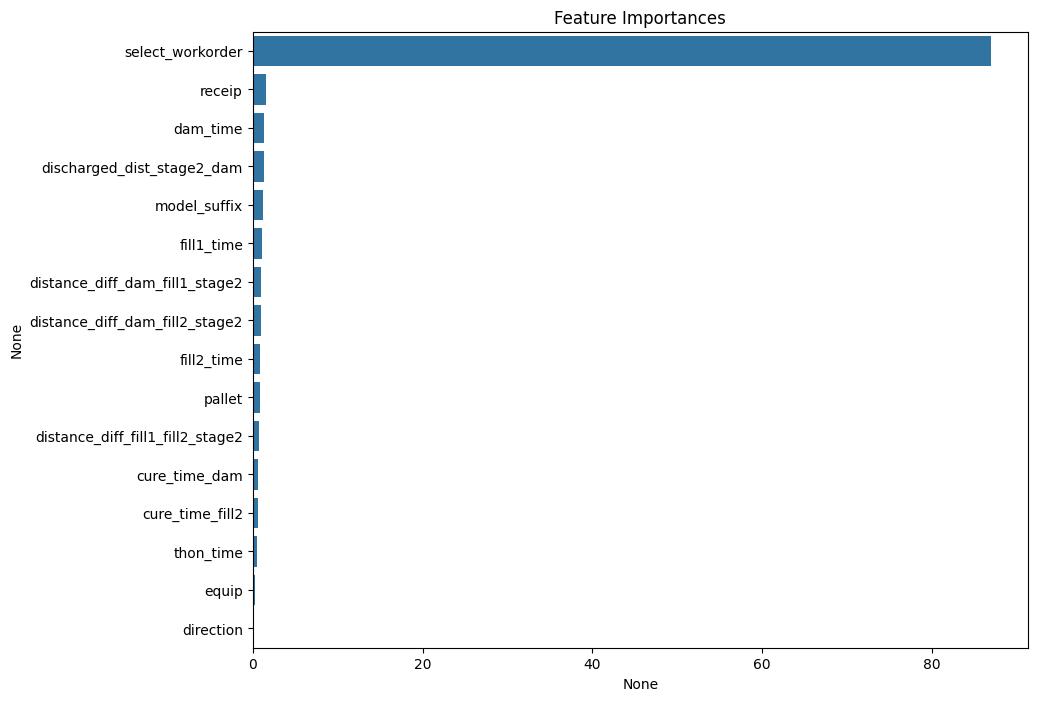

In [18]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(fill1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [19]:
pred = fill1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 138  342]
 [ 603 7000]]

정확도: 0.8831
정밀도: 0.1862
재현율: 0.2875
F1: 0.2260


# Stage3

In [20]:
X_fill2 = df_fill2.drop(columns=['target'])
y_fill2 = df_fill2['target']

cat_features_indices_fill2 = ['pallet', 'receip', 'model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_fill2, y_fill2, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_fill2)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_fill2)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 08:07:57,578] A new study created in memory with name: no-name-d6667750-b0a2-489a-b272-a59bdb2e2bdf
[I 2024-08-15 08:08:07,279] Trial 0 finished with value: 0.5775828542448258 and parameters: {'iterations': 767, 'depth': 7, 'learning_rate': 0.01143235911934028, 'l2_leaf_reg': 7.974856505028704, 'border_count': 84, 'random_strength': 2.9740747174611606, 'bagging_temperature': 0.12364670201163652, 'od_type': 'IncToDec', 'od_wait': 32, 'boosting_type': 'Plain', 'scale_pos_weight': 12}. Best is trial 0 with value: 0.5775828542448258.
[I 2024-08-15 08:08:08,511] Trial 1 finished with value: 0.5815073715050096 and parameters: {'iterations': 140, 'depth': 5, 'learning_rate': 0.0015520417790285113, 'l2_leaf_reg': 3.889528511879942, 'border_count': 209, 'random_strength': 3.4281896595166406, 'bagging_temperature': 0.6437064441986982, 'od_type': 'IncToDec', 'od_wait': 20, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 1 with value: 0.5815073715050096.
[I 2024-08-

Best trial:
  Value: 0.581824687308338
  Params: 
    iterations: 634
    depth: 9
    learning_rate: 0.010347047901666176
    l2_leaf_reg: 1.0907279893490858
    border_count: 179
    random_strength: 5.041051031898376
    bagging_temperature: 0.4330419800130715
    od_type: IncToDec
    od_wait: 20
    boosting_type: Ordered
    scale_pos_weight: 8


In [21]:
study.best_trial.params

{'iterations': 634,
 'depth': 9,
 'learning_rate': 0.010347047901666176,
 'l2_leaf_reg': 1.0907279893490858,
 'border_count': 179,
 'random_strength': 5.041051031898376,
 'bagging_temperature': 0.4330419800130715,
 'od_type': 'IncToDec',
 'od_wait': 20,
 'boosting_type': 'Ordered',
 'scale_pos_weight': 8}

In [22]:
# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(**fill2_best_params)
fill2_best_model.fit(X_train, y_train, cat_features=cat_features_indices_fill2)

0:	learn: 0.6909391	total: 12.9ms	remaining: 8.14s
1:	learn: 0.6886279	total: 38.9ms	remaining: 12.3s
2:	learn: 0.6837779	total: 100ms	remaining: 21.1s
3:	learn: 0.6797889	total: 124ms	remaining: 19.6s
4:	learn: 0.6784971	total: 138ms	remaining: 17.3s
5:	learn: 0.6762676	total: 165ms	remaining: 17.3s
6:	learn: 0.6722859	total: 227ms	remaining: 20.3s
7:	learn: 0.6700213	total: 287ms	remaining: 22.5s
8:	learn: 0.6678225	total: 327ms	remaining: 22.7s
9:	learn: 0.6656377	total: 387ms	remaining: 24.1s
10:	learn: 0.6645163	total: 404ms	remaining: 22.9s
11:	learn: 0.6624678	total: 463ms	remaining: 24s
12:	learn: 0.6614050	total: 473ms	remaining: 22.6s
13:	learn: 0.6599353	total: 530ms	remaining: 23.5s
14:	learn: 0.6563715	total: 592ms	remaining: 24.4s
15:	learn: 0.6545051	total: 653ms	remaining: 25.2s
16:	learn: 0.6510788	total: 709ms	remaining: 25.7s
17:	learn: 0.6494555	total: 736ms	remaining: 25.2s
18:	learn: 0.6461405	total: 778ms	remaining: 25.2s
19:	learn: 0.6430695	total: 836ms	remaini

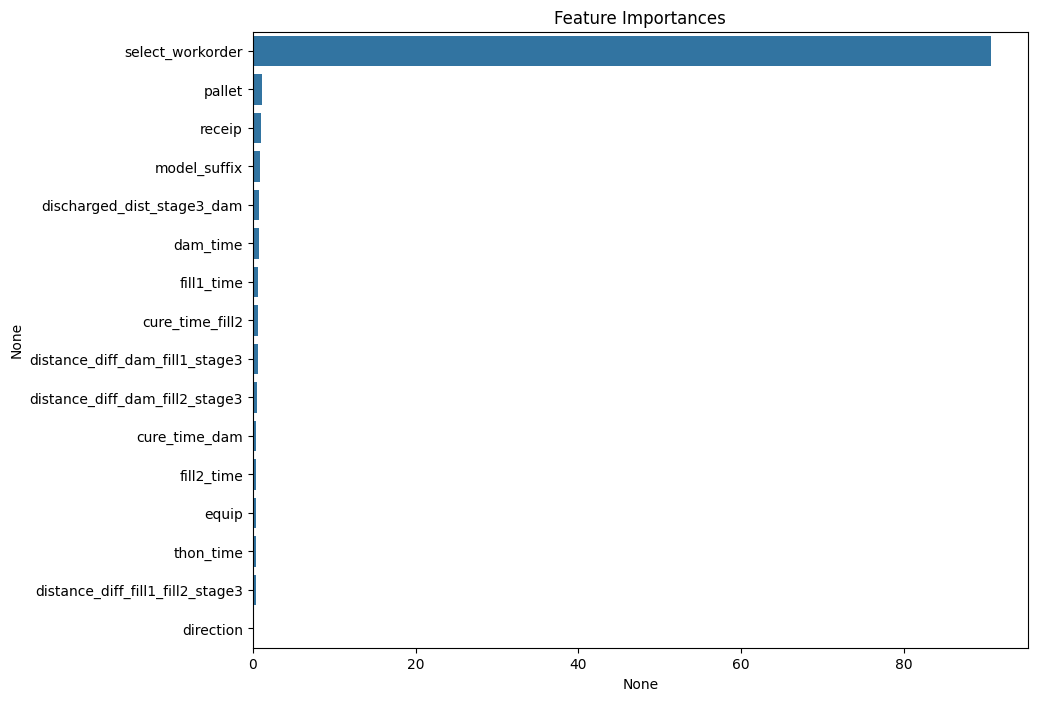

In [23]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(fill2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [24]:
pred = fill2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[ 140  340]
 [ 605 6998]]

정확도: 0.8831
정밀도: 0.1879
재현율: 0.2917
F1: 0.2286


# AutoClave

In [25]:
X_AutoClave = df_autoclave.drop(columns=['target'])
y_AutoClave = df_autoclave['target']

cat_features_indices_autoclave = ['pallet', 'receip', 'model_suffix', 'chamber_temp']

X_train, X_valid, y_train, y_valid = train_test_split(X_AutoClave, y_AutoClave, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_autoclave)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_autoclave)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 1, 20),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-15 08:19:26,480] A new study created in memory with name: no-name-b334f214-9096-4e7a-beb9-dae04f7f7fbc
[I 2024-08-15 08:19:41,977] Trial 0 finished with value: 0.5701826508473204 and parameters: {'iterations': 744, 'depth': 8, 'learning_rate': 0.0167358392177229, 'l2_leaf_reg': 4.277144181016919, 'border_count': 217, 'random_strength': 5.945538734972634, 'bagging_temperature': 0.2118136159748396, 'od_type': 'IncToDec', 'od_wait': 31, 'boosting_type': 'Ordered', 'scale_pos_weight': 14}. Best is trial 0 with value: 0.5701826508473204.
[I 2024-08-15 08:19:42,922] Trial 1 finished with value: 0.5526612579948426 and parameters: {'iterations': 125, 'depth': 5, 'learning_rate': 0.29868269965115973, 'l2_leaf_reg': 9.398800548806646, 'border_count': 32, 'random_strength': 2.41105858809204, 'bagging_temperature': 0.14687879646795676, 'od_type': 'IncToDec', 'od_wait': 50, 'boosting_type': 'Ordered', 'scale_pos_weight': 15}. Best is trial 0 with value: 0.5701826508473204.
[I 2024-08-15 

Best trial:
  Value: 0.5848626505659804
  Params: 
    iterations: 871
    depth: 5
    learning_rate: 0.002040916474995722
    l2_leaf_reg: 1.0036436670635454
    border_count: 190
    random_strength: 5.439808934142301
    bagging_temperature: 0.8030152961823152
    od_type: Iter
    od_wait: 27
    boosting_type: Plain
    scale_pos_weight: 8


In [26]:
study.best_trial.params

{'iterations': 871,
 'depth': 5,
 'learning_rate': 0.002040916474995722,
 'l2_leaf_reg': 1.0036436670635454,
 'border_count': 190,
 'random_strength': 5.439808934142301,
 'bagging_temperature': 0.8030152961823152,
 'od_type': 'Iter',
 'od_wait': 27,
 'boosting_type': 'Plain',
 'scale_pos_weight': 8}

In [27]:
# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(**AutoClave_best_params)
AutoClave_best_model.fit(X_train, y_train, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6922672	total: 14.7ms	remaining: 12.8s
1:	learn: 0.6918179	total: 26.1ms	remaining: 11.3s
2:	learn: 0.6908603	total: 37.9ms	remaining: 11s
3:	learn: 0.6904297	total: 45.4ms	remaining: 9.85s
4:	learn: 0.6901186	total: 58.2ms	remaining: 10.1s
5:	learn: 0.6898140	total: 66ms	remaining: 9.51s
6:	learn: 0.6895173	total: 75.6ms	remaining: 9.33s
7:	learn: 0.6890781	total: 86.2ms	remaining: 9.3s
8:	learn: 0.6887762	total: 94.2ms	remaining: 9.02s
9:	learn: 0.6883423	total: 102ms	remaining: 8.8s
10:	learn: 0.6880701	total: 110ms	remaining: 8.6s
11:	learn: 0.6871117	total: 122ms	remaining: 8.72s
12:	learn: 0.6868429	total: 128ms	remaining: 8.47s
13:	learn: 0.6863943	total: 140ms	remaining: 8.58s
14:	learn: 0.6859682	total: 150ms	remaining: 8.57s
15:	learn: 0.6855483	total: 160ms	remaining: 8.56s
16:	learn: 0.6847913	total: 176ms	remaining: 8.82s
17:	learn: 0.6843785	total: 185ms	remaining: 8.78s
18:	learn: 0.6841172	total: 191ms	remaining: 8.56s
19:	learn: 0.6838570	total: 196ms	remai

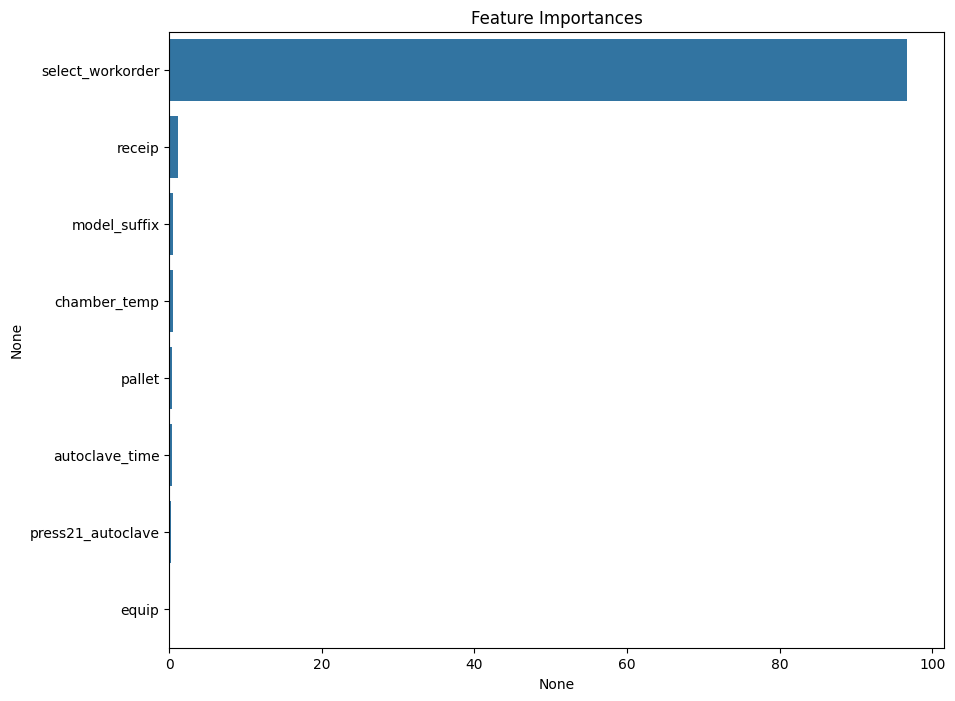

In [28]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(AutoClave_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [29]:
pred = AutoClave_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  57  423]
 [ 177 7426]]

정확도: 0.9258
정밀도: 0.2436
재현율: 0.1187
F1: 0.1597


# 민감성

In [30]:
# 최적의 하이퍼파라미터로 모델 재학습
dam_best_params = study.best_trial.params
dam_best_model = CatBoostClassifier(**dam_best_params)
dam_best_model.fit(X_dam, y_dam, cat_features=cat_features_indices_dam)

# 최적의 하이퍼파라미터로 모델 재학습
fill1_best_params = study.best_trial.params
fill1_best_model = CatBoostClassifier(**fill1_best_params)
fill1_best_model.fit(X_fill1, y_fill1, cat_features=cat_features_indices_fill1)

# 최적의 하이퍼파라미터로 모델 재학습
fill2_best_params = study.best_trial.params
fill2_best_model = CatBoostClassifier(**fill2_best_params)
fill2_best_model.fit(X_fill2, y_fill2, cat_features=cat_features_indices_fill2)

# 최적의 하이퍼파라미터로 모델 재학습
AutoClave_best_params = study.best_trial.params
AutoClave_best_model = CatBoostClassifier(**AutoClave_best_params)
AutoClave_best_model.fit(X_AutoClave, y_AutoClave, cat_features=cat_features_indices_autoclave)

0:	learn: 0.6928490	total: 20.2ms	remaining: 17.6s
1:	learn: 0.6923842	total: 42.3ms	remaining: 18.4s
2:	learn: 0.6919218	total: 63.2ms	remaining: 18.3s
3:	learn: 0.6914640	total: 81.4ms	remaining: 17.6s
4:	learn: 0.6910213	total: 98.7ms	remaining: 17.1s
5:	learn: 0.6905615	total: 115ms	remaining: 16.6s
6:	learn: 0.6896995	total: 130ms	remaining: 16.1s
7:	learn: 0.6892630	total: 145ms	remaining: 15.7s
8:	learn: 0.6888316	total: 159ms	remaining: 15.2s
9:	learn: 0.6885145	total: 174ms	remaining: 15s
10:	learn: 0.6880559	total: 189ms	remaining: 14.8s
11:	learn: 0.6876169	total: 203ms	remaining: 14.5s
12:	learn: 0.6871619	total: 217ms	remaining: 14.3s
13:	learn: 0.6862266	total: 233ms	remaining: 14.3s
14:	learn: 0.6857931	total: 247ms	remaining: 14.1s
15:	learn: 0.6848953	total: 262ms	remaining: 14s
16:	learn: 0.6844675	total: 276ms	remaining: 13.9s
17:	learn: 0.6841984	total: 285ms	remaining: 13.5s
18:	learn: 0.6832658	total: 301ms	remaining: 13.5s
19:	learn: 0.6829682	total: 316ms	remain

In [31]:
test_dam_x = test[X_dam.columns]
test_fill1_x = test[X_fill1.columns]
test_fill2_x = test[X_fill2.columns]
test_AutoClave_x = test[X_AutoClave.columns]

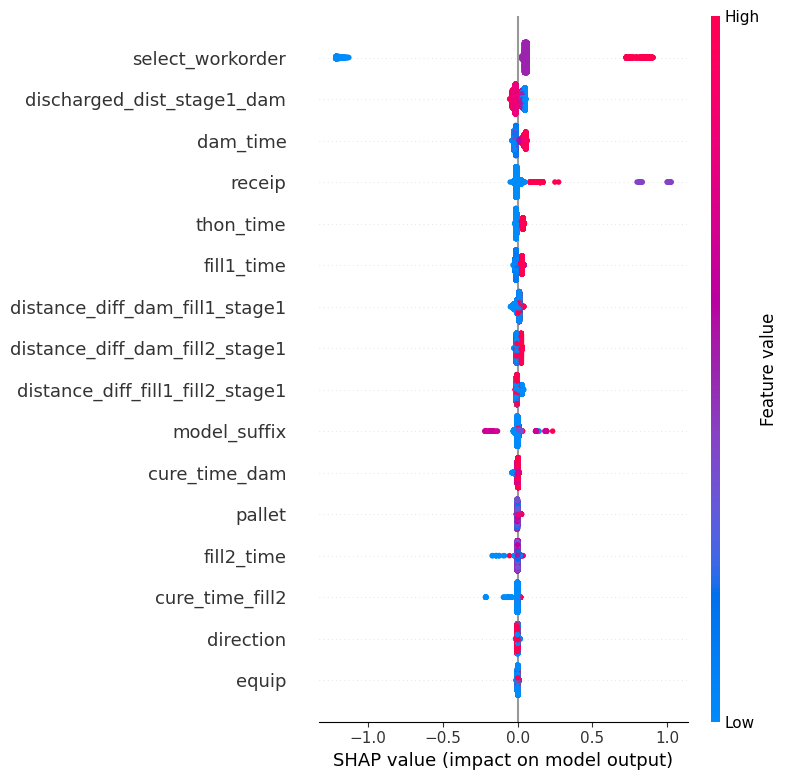

In [32]:
explainer = shap.Explainer(dam_best_model)
shap_values = explainer(test_dam_x)
shap.initjs()

shap.summary_plot(shap_values, test_dam_x)

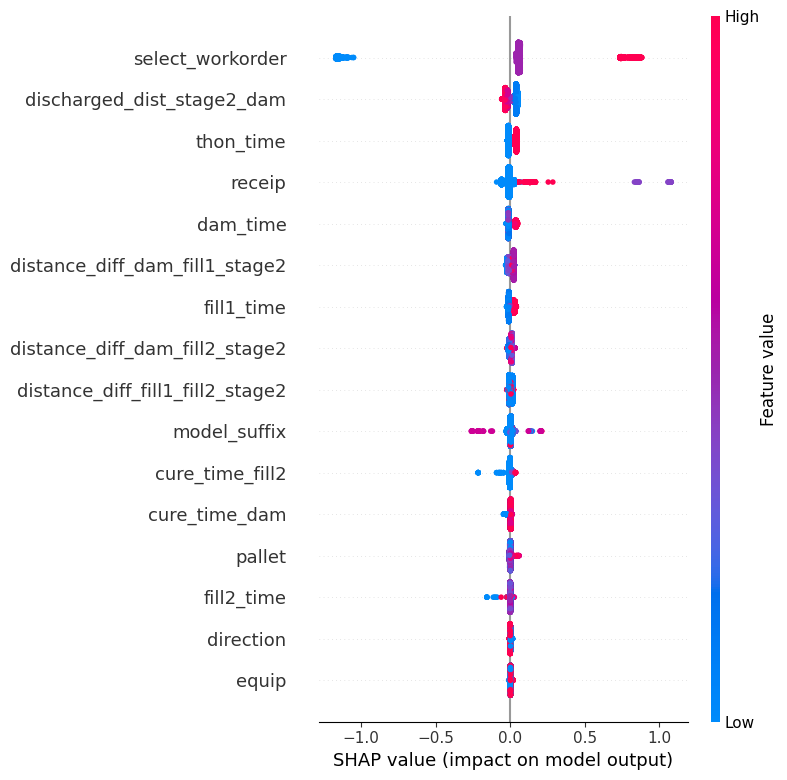

In [33]:
explainer = shap.Explainer(fill1_best_model)
shap_values = explainer(test_fill1_x)
shap.initjs()

shap.summary_plot(shap_values, test_fill1_x)

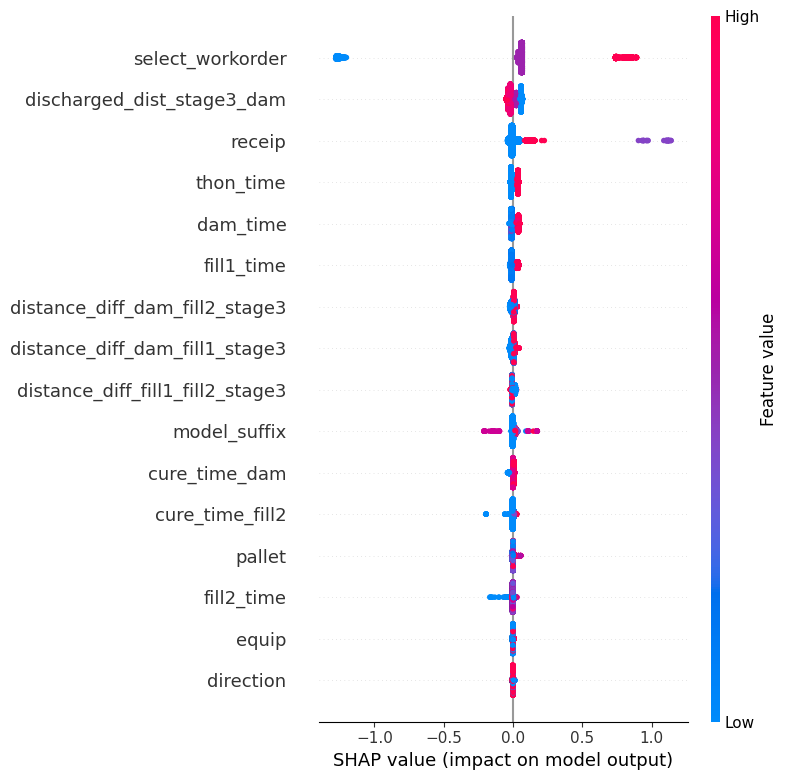

In [34]:
explainer = shap.Explainer(fill2_best_model)
shap_values = explainer(test_fill2_x)
shap.initjs()

shap.summary_plot(shap_values, test_fill2_x)

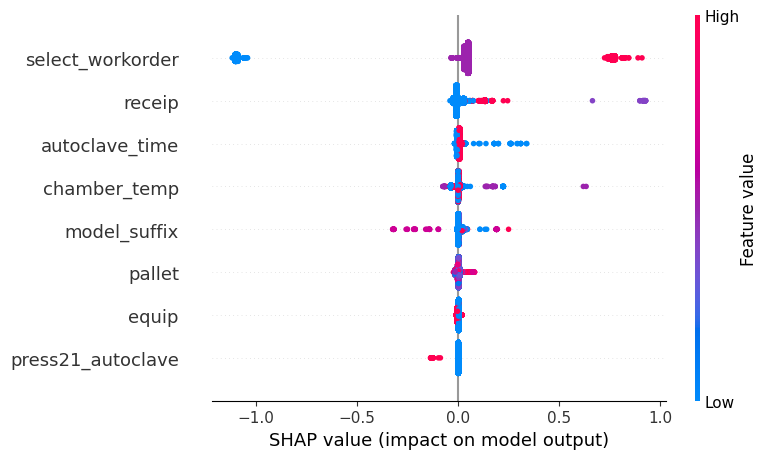

In [35]:
explainer = shap.Explainer(AutoClave_best_model)
shap_values = explainer(test_AutoClave_x)
shap.initjs()

shap.summary_plot(shap_values, test_AutoClave_x)

In [36]:
dam_test_pred = dam_best_model.predict(test_dam_x)
dam_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
fill1_test_pred = fill1_best_model.predict(test_fill1_x)
fill1_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
fill2_test_pred = fill2_best_model.predict(test_fill2_x)
fill2_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
AutoClave_test_pred = AutoClave_best_model.predict(test_AutoClave_x)
AutoClave_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
result = np.logical_or(dam_test_pred, fill1_test_pred)
result = np.logical_or(result, fill2_test_pred)
result = np.logical_or(result, AutoClave_test_pred)

In [41]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [42]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([ 1635, 15726]))

In [43]:
test['target'] = y_pred

In [45]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,1624,15709
1,11,17


In [50]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [51]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,1624,15709
1,28,0


In [52]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)